For exploration of the cfbp complaints data.

To beign with we  have been provided with a dataset of over 350,000 such complaints for 5 common issue types. 
**Our goal is to train a text classification model to identify the issue type based on the consumer complaint narrative.**
The data can be downloaded from https://drive.google.com/file/d/1Hz1gnCCr-SDGjnKgcPbg7Nd3NztOLdxw/view?usp=share_link

This is a subset of a larger dataset which has 20 more common issues https://drive.google.com/file/d/1gW6LScUL-Z7mH6gUZn-1aNzm4p4CvtpL/view?usp=share_link.

Objective is to find a model to that can do the most predictions in right bucket.


In [1]:
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse.linalg import svds

from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize


from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
reviews = pd.read_csv('../data/complaints.csv').dropna().reset_index(drop = True)
reviews.head()
reviews.shape #(353432, 2)

(353432, 2)

In [3]:
#How many complaints per issue
reviews['Issue'].value_counts()
# reviews['Issue'].value_counts().plot(kind='bar');

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: Issue, dtype: int64

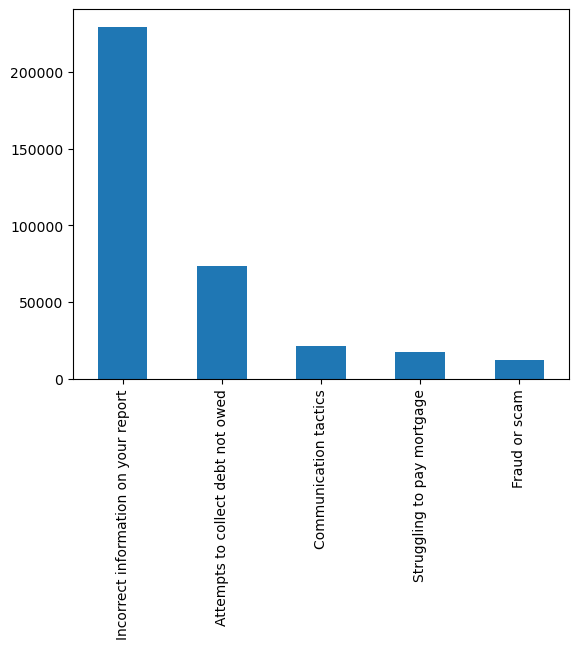

In [4]:
reviews['Issue'].value_counts().plot(kind='bar');

#create a sentiemnt column based on the issues.
This is a multiclass classification problem we will have to follow that path we can not have the sentiement column.

In [5]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Incorrect information on your report", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

I just reviewed a copy of my Experian credit report and found the following information to be an error. I am a victim of identity theft and did not make these charges. I reported the theft of my identity to the Federal Trade Commission.
-----------------------------
after my legal separation from my husband he started to open credit in my name with no permission I have a legal case against him but can not find him he has ruined my life his name is XXXX XXXX XXXX   remove I have disputed by mail with all three credit bureaus. act # XXXX owing an alleged {$2200.00} XXXX   XXXX  orig creditor XXXX
-----------------------------
Equifax report a collections account " XXXX XXXX XXXX ''. I have no knowledge of this account. I have not been furnished any proof or verifications of this account. I don't have any signed contract agreements with XXXX XXXX XXXX, verbal agreements nor any paperwork associated with them. A proper investigation according to FCRA was not conducted, word of mouth from t

In [6]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Attempts to collect debt not owed", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

This company in which I hold no contract with nor have received services from reported ( 3 ) different collection accounts against my Social Security Number in the amount of {$510.00}, {$710.00} and {$570.00} with XXXX, XXXX & XXXX   credit reporting agencies. I requested verification and validation on XX/XX/2018 of the alleged debt and account, however, the business failed to provide adequate proof. Considering this business does not have a contract with me for goods or services they have provided nor have they provided adequate proof, I am not obligated to pay for the alleged debt.
-----------------------------
An affidavit of Billing Error Notice was mailed to XXXX XXXX XXXX XXXX and/or XXXX, XXXX but they didn't respond back. 

The account is an agreement, not a contract. Based on the consumer protection laws and your lack of complete disclosure I rescind the entire transaction due to fraud. 

CONSUMER PROTECTION LAWS and U.S. CODE VIOLATIONS : Equal Credit Opportunity Act / Truth 

In [7]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Fraud or scam", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

I am disputing Wells Fargos response ( Wells Fargo case # : XXXX ). Please thoroughly answer the following question : WHERE WERE THE FUNDS TRANSFERRED TO ( i.e., bank account, etc.? 

WHO RECEIVED THE FUNDS ( i.e., persons first and last name )? 

I am asking these questions because I DID NOT AUTHORIZE A TRANSFER OF MY MONEY TO ANYONE!! 

Please answered questions indicated above.
-----------------------------
I have a PayPal XXXX account for my company XXXX XXXX. During the year 2019, I was operating a PayPal account using my company 's email ( XXXX ) and tried to sell items that PayPal did not allow for the sale of in their acceptable items list. I was selling Vaporizers in accordance with Oklahoma law where I was selling them. PayPal 's brand risk department and I spoke through email correspondence and resolved the issue I removed all vaporizers from my store and stopped selling them. 
PayPal then fully reactivated my account, and I did not try to sell vaporizers anymore instead men

#looking at the test I want to know what are the issues most offten reported in the complents like the key words equifax, divorse etc.

In [8]:
reviews['Consumer complaint narrative'].str.contains(r'\b[D|d]ivorce\b', regex = True).value_counts()

False    351936
True       1496
Name: Consumer complaint narrative, dtype: int64

In [9]:
#there are words at the beigning versus in the text so we are going to lower case to avoid duplication.
reviews['Consumer complaint narrative'] = reviews['Consumer complaint narrative'].str.lower()

Steps to follow for sentiment analysis and classification
1. Split and filter text data in preparation for analysis
2. Analyze word frequency
3. Find concordance and collocations using different methods
4. Perform quick sentiment analysis with NLTK’s built-in classifier
5. Define features for custom classification
6. Use and compare classifiers for sentiment analysis with NLTK

In [10]:
reviews['Consumer complaint narrative']

0         my name is xxxx xxxx this complaint is not mad...
1         i searched on xxxx for xxxxxxxx xxxx  and was ...
2         i have a particular account that is stating th...
3         i have not supplied proof under the doctrine o...
4         hello i'm writing regarding account on my cred...
                                ...                        
353427           collections account i have no knowledge of
353428    dear cfpb team, the reason for my complaint is...
353429    frca violations : failing to follow debt dispu...
353430    my father, a xxxx xxxx  acquired an hecm rever...
353431    i have tried to contact cash app about a fraud...
Name: Consumer complaint narrative, Length: 353432, dtype: object

In [136]:
# reviews['complaint_clean'] = reviews['Consumer complaint narrative'].str.replace('X', '').str.replace('//', '').str.replace('.00', '')

reviews['complaint_clean'] = (reviews['Consumer complaint narrative'].str.replace('X', '')
                                 .str.replace('//', '').str.replace('.00', '').str.replace('xxxx', '')
                                 .str.replace('xx', ''))

C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\2763292358.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['complaint_clean'] = (reviews['Consumer complaint narrative'].str.replace('X', '')


In [137]:
X = reviews[['Consumer complaint narrative']]
y = reviews['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)


In [138]:
X_train.shape
X_train.head()

,Consumer complaint narrative
259439,i filed an identity theft report when i learne...
250809,on xx/xx/2021 xxxx xxxx xxxx closed my accoun...
173966,it has been a battle going through this and i ...
38815,i noticed a debt for {$240.00} on my credit re...
62264,"currently, ncc business services of xxxx, fl i..."


In [139]:
vect = CountVectorizer()
    
vect.fit(X_train['Consumer complaint narrative'])
X_train_vec = vect.transform(X_train['Consumer complaint narrative'])
# X_train_vec
X_test_vec = vect.transform(X_test['Consumer complaint narrative'])

# X_test_vec
X_train_vec

<265074x72222 sparse matrix of type '<class 'numpy.int64'>'
	with 21821225 stored elements in Compressed Sparse Row format>

In [140]:
#we want to take a look at all of the tokens that the CountVectorizer has seen, we can look at its vocabulary. Check the vocabulary_ attribute.

vocb_dic = vect.vocabulary_
vocb_dic

{'filed': 27623,
 'an': 7588,
 'identity': 33193,
 'theft': 62695,
 'report': 53519,
 'when': 69157,
 'learned': 38240,
 'that': 62471,
 'someone': 58801,
 'was': 68649,
 'using': 67154,
 'my': 42576,
 'during': 23633,
 'incarceration': 34187,
 'submitted': 60580,
 'documentation': 22940,
 'about': 4759,
 'and': 7647,
 'xxxx': 70263,
 'transunion': 64522,
 'disregarded': 22530,
 'it': 36686,
 'they': 63019,
 'didn': 21574,
 'even': 25757,
 'block': 11937,
 'the': 62544,
 'account': 5119,
 'for': 28383,
 '30': 2342,
 'days': 19692,
 'upon': 66905,
 'receiving': 51732,
 'information': 34901,
 'also': 7208,
 'received': 51702,
 'letter': 38533,
 'from': 29305,
 'irs': 36537,
 'stating': 59803,
 'tax': 61898,
 'return': 54689,
 'in': 33986,
 'name': 42788,
 'us': 66998,
 'dept': 20936,
 'of': 44819,
 'educatio': 23998,
 'acct': 5259,
 'on': 45170,
 'xx': 70253,
 '2021': 1798,
 'closed': 15445,
 'send': 56896,
 'written': 70050,
 'notification': 44066,
 'will': 69437,
 'be': 10934,
 'report

In [142]:
#How many total tokens are there? #Total count of token(words) in the vocabulary: 72222

key_sum = len(vocb_dic.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

Total count of token(words) in the vocabulary: 72222


In [143]:
# finding the frequecy of the token

# Fill this in to build a DataFrame of words and their counts
word_counts = pd.DataFrame({
    'words': vect.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_vec.sum(axis = 0)).flatten()
})

word_counts

,words,frequency
0,00,240072
1,000,1069
2,0000,10
3,00000,7
4,0000000000000000000000000000000000000000000000...,4
...,...,...
72217,zwicke,1
72218,zwicker,80
72219,zwickerpc,1
72220,zwickers,1


In [144]:
word_counts[word_counts['words']=='equifax']['frequency']

25243    38717
Name: frequency, dtype: int64

# remove the stop words to reduce the features*
### use the complaints_clean column for analysis
# find the probabiliy of tokens most associated with a category
# ?CountVectorizer

In [145]:
X = reviews[['complaint_clean']]
y = reviews['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)


In [146]:
type(stopwords.words('english'))

list

In [147]:

vect = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect.fit(X_train['complaint_clean'])
X_train_vec = vect.transform(X_train['complaint_clean'])
# X_train_vec
X_test_vec = vect.transform(X_test['complaint_clean'])

# X_test_vec
X_train_vec

<265074x68988 sparse matrix of type '<class 'numpy.int64'>'
	with 14367129 stored elements in Compressed Sparse Row format>

In [148]:
vocb_dic1 = vect.vocabulary_
vocb_dic1

{'filed': 26759,
 'identity': 32225,
 'theft': 61263,
 'report': 52230,
 'learned': 37191,
 'someone': 57430,
 'using': 65628,
 'incarceration': 33213,
 'submitted': 59193,
 'documentation': 22121,
 'transunion': 63031,
 'disregarded': 21714,
 'even': 24922,
 'block': 11321,
 'account': 4646,
 '30': 2140,
 'days': 18929,
 'upon': 65384,
 'receiving': 50457,
 'information': 33919,
 'also': 6682,
 'received': 50428,
 'letter': 37478,
 'irs': 35530,
 'stating': 58417,
 'tax': 60481,
 'return': 53375,
 'name': 41647,
 'us': 65479,
 'dept': 20147,
 'educatio': 23168,
 'acct': 4782,
 '2021': 1631,
 'closed': 14763,
 'send': 55561,
 'written': 68462,
 'notification': 42898,
 'reported': 52244,
 'consumer': 16682,
 'reporting': 52271,
 'agencies': 5981,
 'never': 42254,
 'ever': 24950,
 'late': 36950,
 'although': 6733,
 'updated': 65323,
 'chargeoff': 13915,
 'providing': 49079,
 'severe': 55943,
 'scandalous': 54854,
 'action': 5091,
 'destroying': 20451,
 'perfect': 46231,
 'payment': 45842

In [150]:
key_sum = len(vocb_dic1.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

##Total count of token(words) in the vocabulary: 71931 (with stop words) #after secondcleaning it reduced fro 71788 to 68988

Total count of token(words) in the vocabulary: 68988


In [151]:
# Fill this in to build a DataFrame of words and their counts
word_counts1 = pd.DataFrame({
    'words': vect.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_vec.sum(axis = 0)).flatten()
})

word_counts1

,words,frequency
0,00,5368
1,001,2
2,0017425527,1
3,01,240
4,010,8
...,...,...
68983,zwicke,1
68984,zwicker,80
68985,zwickerpc,1
68986,zwickers,1


In [152]:
word_counts1.sort_values('frequency', ascending=False).head()

,words,frequency
18003,credit,552517
4646,account,375701
52230,report,314041
33919,information,290363
52271,reporting,213054


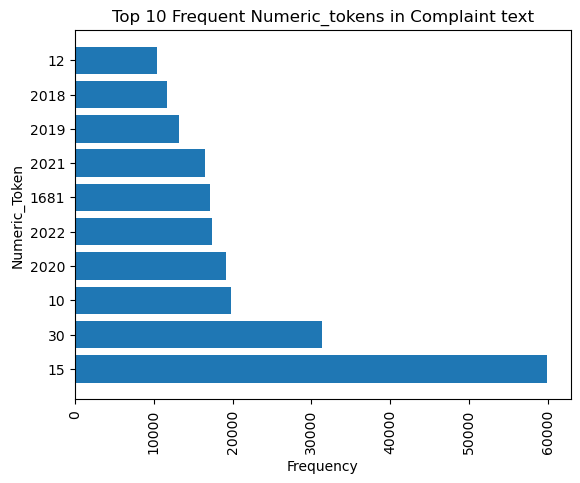

In [153]:
numeric_words = (word_counts1[word_counts1['words'].str.isnumeric()].sort_values('frequency',ascending=False)
 .head(10))

import matplotlib.pyplot as plt

plt.barh(numeric_words.words, numeric_words.frequency)
plt.xticks(rotation=90)
plt.xlabel("Frequency")
plt.ylabel("Numeric_Token")
plt.title("Top 10 Frequent Numeric_tokens in Complaint text")
plt.show()

In [156]:
(word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
) #69814 rows × 2 columns. Top two  were XXXX (4146048) and xx (821131) all XXXX and XX is gone now and now we have 67003 rows × 2 columns

,words,frequency
18003,credit,552517
4646,account,375701
52230,report,314041
33919,information,290363
52271,reporting,213054
...,...,...
33252,incesting,1
33256,inching,1
33263,incidentals,1
33265,incidicating,1


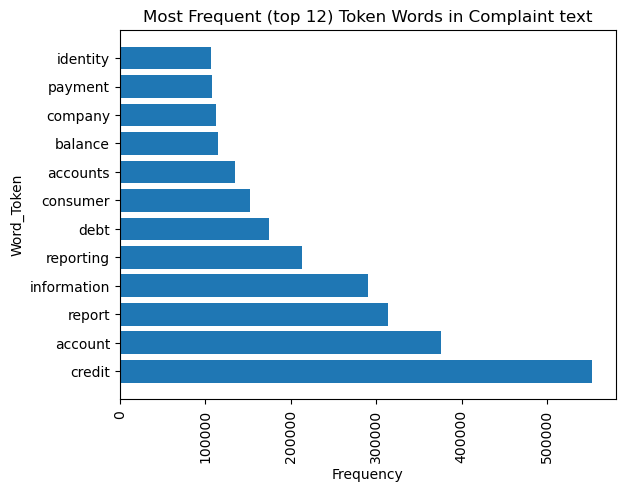

In [158]:
(word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]) #69814 rows × 2 columns. Top two  were XXXX (4146048) and xx (821131); 67003 rows × 2 column

plt.barh((word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words, (word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)
plt.xticks(rotation=90)
plt.xlabel("Frequency")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 12) Token Words in Complaint text")
plt.show()

### next step to find token frequency per category.

In [159]:
reviews["Issue"].value_counts()

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: Issue, dtype: int64

In [160]:
incorrect_info = reviews[reviews["Issue"]=="Incorrect information on your report"]
collect_debt = reviews[reviews["Issue"]=="Attempts to collect debt not owed"]
pay_mortgage = reviews[reviews["Issue"]=="Struggling to pay mortgage"]
comm_tactics = reviews[reviews["Issue"]=="Communication tactics"]
fraud = reviews[reviews["Issue"]=="Fraud or scam"]

In [161]:
vect1 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect_incorrect_info = vect1.fit(incorrect_info['complaint_clean'])
X_train_incorrect_info = vect1.transform(incorrect_info['complaint_clean'])


vocb_incorrect_info = vect1.vocabulary_
vocb_incorrect_info

{'name': 29250,
 'complaint': 11062,
 'made': 27245,
 'error': 17369,
 'neither': 29608,
 'third': 43066,
 'party': 31995,
 'declare': 13464,
 'penalty': 32284,
 'perjury': 32418,
 'alleging': 4639,
 'person': 32537,
 'company': 10971,
 'without': 47480,
 'authorization': 6510,
 'unauthorized': 44685,
 'use': 45794,
 'social': 39999,
 'security': 38727,
 'number': 30319,
 'card': 9091,
 'used': 45799,
 'personal': 32542,
 'identifying': 22576,
 'information': 23953,
 'apply': 5575,
 'goods': 20810,
 'services': 39006,
 'money': 28650,
 'successful': 41475,
 'creating': 12570,
 'accounts': 3291,
 'knowledge': 25888,
 'investigated': 24918,
 'ftc': 20170,
 '15': 383,
 'code': 10480,
 '1681b': 569,
 'permissible': 32460,
 'purposes': 34519,
 'consumer': 11684,
 'reports': 36602,
 'never': 29687,
 'gave': 20486,
 'written': 47749,
 'consent': 11523,
 'report': 36521,
 'anything': 5367,
 'date': 13189,
 'opened': 31075,
 '2018': 1070,
 'balance': 6903,
 '90': 2619,
 'please': 32976,
 'delet

In [162]:
key_sum = len(vocb_incorrect_info.keys())
print("Total count of token(words) in the vocabulary:", key_sum) 

#previously it was Total count of token(words) in the vocabulary: 50395 now reduced to 48096

Total count of token(words) in the vocabulary: 48096


In [163]:
word_counts_incorrect_info = pd.DataFrame({
    'words': vect1.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_incorrect_info.sum(axis = 0)).flatten()
})


In [165]:
word_counts_incorrect_info.sort_values('frequency', ascending=False) #50395 rows × 2 columns; 48096 rows × 2 columns

,words,frequency
12611,credit,577009
3246,account,349549
36521,report,344232
23953,information,293357
36560,reporting,234006
...,...,...
36163,remdered,1
36164,reme,1
8866,caid,1
4234,againsed,1


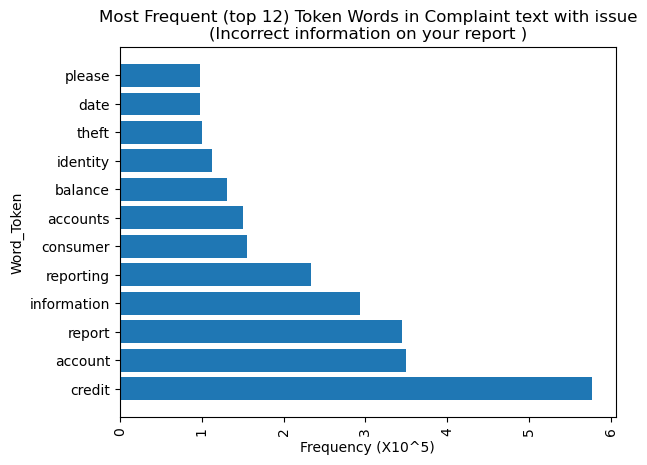

In [167]:
(word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (4286797) and xx (756808); the tokens xxxx and xx are now gone in second cleaning

plt.barh((word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words,
        ((word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 12) Token Words in Complaint text with issue\n(Incorrect information on your report )")
plt.show()

### collect_debt

In [168]:
vect2 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect2.fit(collect_debt['complaint_clean'])
X_train_collect_debt = vect2.transform(collect_debt['complaint_clean'])
vocb_collect_debt = vect2.vocabulary_
vocb_collect_debt
key_sum = len(vocb_collect_debt.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_collect_debt = pd.DataFrame({
    'words': vect2.get_feature_names_out(), 
    'frequency': np.array(X_train_collect_debt.sum(axis = 0)).flatten()
})

Total count of token(words) in the vocabulary: 36732


In [170]:
(word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (669978) and xx (156653); 35481

,words,frequency
9683,credit,140766
10215,debt,129525
2373,account,105354
18021,information,70246
27853,report,65987
...,...,...
18025,informationincluding,1
18024,informationconcerning,1
18023,informationbased,1
18020,informatioin,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\2836630476.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_collect_debt[~word_counts1['words'].str.isnumeric()].


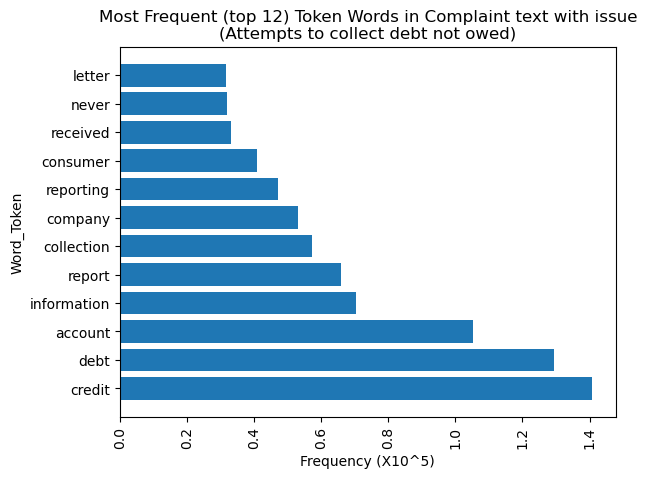

In [172]:
(word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (669978) and xx (156653)

plt.barh((word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words, 
         ((word_counts_collect_debt[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 12) Token Words in Complaint text with issue\n(Attempts to collect debt not owed)")
plt.show()

## pay_mortgage 

In [173]:
vect3 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect3.fit(pay_mortgage['complaint_clean'])
X_train_pay_mortgage = vect3.transform(pay_mortgage['complaint_clean'])
vocb_pay_mortgage = vect3.vocabulary_
vocb_pay_mortgage
key_sum = len(vocb_pay_mortgage.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_pay_mortagage = pd.DataFrame({
    'words': vect3.get_feature_names_out(), 
    'frequency': np.array(X_train_pay_mortgage.sum(axis = 0)).flatten()
})
word_counts_pay_mortagage

Total count of token(words) in the vocabulary: 29523


,words,frequency
0,00,1320
1,01,31
2,010,4
3,01093,1
4,015,2
...,...,...
29518,zones,2
29519,zoning,2
29520,zoo,1
29521,zoom,4


C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\297461851.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.barh((word_counts_pay_mortagage[~word_counts_collect_debt['words'].str.isnumeric()].
C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\297461851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_pay_mortagage[~word_counts1['words'].str.isnumeric()].


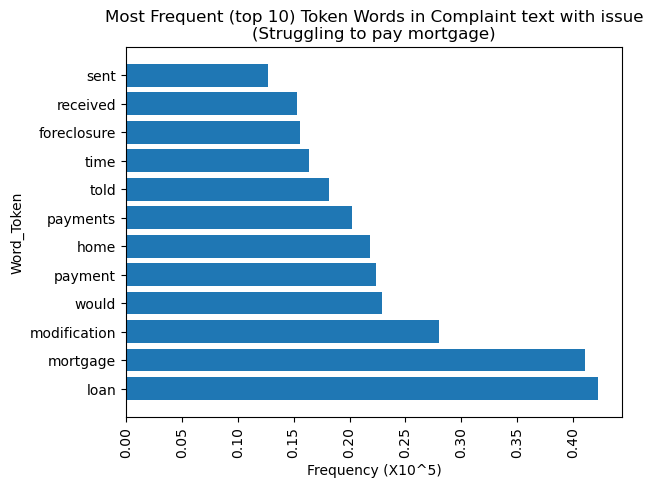

In [176]:
(word_counts_pay_mortagage[~word_counts_pay_mortagage['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #29300 rows × 2 columns. Top two  were XXXX (264660) and xx (104588); now it is 28637 rows × 2 columns

plt.barh((word_counts_pay_mortagage[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words, 
         ((word_counts_pay_mortagage[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Struggling to pay mortgage)")
plt.show()

# Fraud

In [177]:
# fraud = reviews[reviews["Issue"]=="Fraud or scam"]

In [178]:
vect4 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect4.fit(fraud['complaint_clean'])
X_train_fraud = vect4.transform(fraud['complaint_clean'])
vocb_fraud = vect4.vocabulary_
vocb_fraud
key_sum = len(vocb_fraud.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_fraud = pd.DataFrame({
    'words': vect4.get_feature_names_out(), 
    'frequency': np.array(X_train_fraud.sum(axis = 0)).flatten()
})
word_counts_fraud

Total count of token(words) in the vocabulary: 21823


,words,frequency
0,00,743
1,01,3
2,016,1
3,017,1
4,02,5
...,...,...
21818,zones,2
21819,zoom,9
21820,zpass,1
21821,zt,1


In [245]:
(word_counts_fraud[~word_counts_fraud['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #21831 rows × 2 columns. Top two  were XXXX (168616) and xx (40720); 21397 rows × 2 columns

,words,frequency
912,account,27604
12496,money,21549
2450,bank,20364
21626,would,10916
17304,sent,9973
...,...,...
6295,disprove,1
14567,possessing,1
6294,disproportionately,1
14569,possessions,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\4005096228.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.barh((word_counts_fraud[~word_counts_collect_debt['words'].str.isnumeric()].
C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\4005096228.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_fraud[~word_counts1['words'].str.isnumeric()].


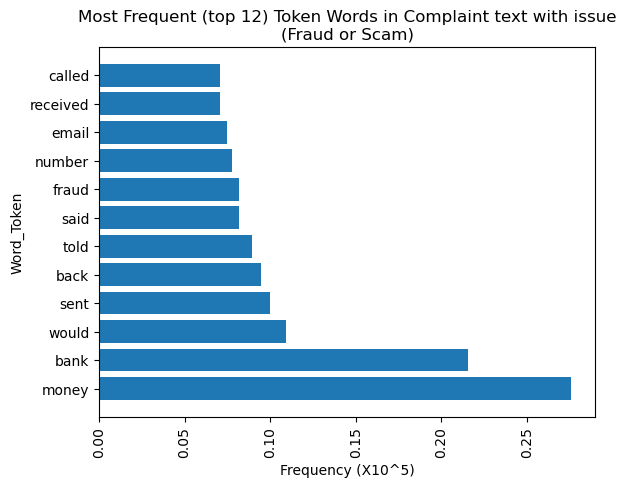

In [180]:
plt.barh((word_counts_fraud[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words, 
         ((word_counts_fraud[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 12) Token Words in Complaint text with issue\n(Fraud or Scam)")
plt.show()

# communication

In [181]:
# comm_tactics = reviews[reviews["Issue"]=="Communication tactics"]

In [182]:
vect5 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect5.fit(comm_tactics['complaint_clean'])
X_train_comm_tactics = vect5.transform(comm_tactics['complaint_clean'])
vocb_comm_tactics = vect5.vocabulary_
vocb_comm_tactics
key_sum = len(vocb_fraud.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_comm_tactics = pd.DataFrame({
    'words': vect5.get_feature_names_out(), 
    'frequency': np.array(X_train_comm_tactics.sum(axis = 0)).flatten()
})

word_counts_comm_tactics

Total count of token(words) in the vocabulary: 21823


,words,frequency
0,00,96
1,01,2
2,02,1
3,03,3
4,04,3
...,...,...
20137,zoom,1
20138,zooms,1
20139,zuntafi,1
20140,zwicker,36


In [244]:
(word_counts_comm_tactics[~word_counts_comm_tactics['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #20029 rows × 2 columns. Top two  were XXXX (128056) and xx (34286); now 19668 rows × 2 columns

,words,frequency
5200,debt,23781
3202,call,23679
13351,phone,17712
3237,calls,15275
3211,called,14728
...,...,...
9876,internantional,1
9877,internat,1
9885,interpreter,1
9886,interpreters,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_6148\4184527802.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_comm_tactics[~word_counts1['words'].str.isnumeric()].


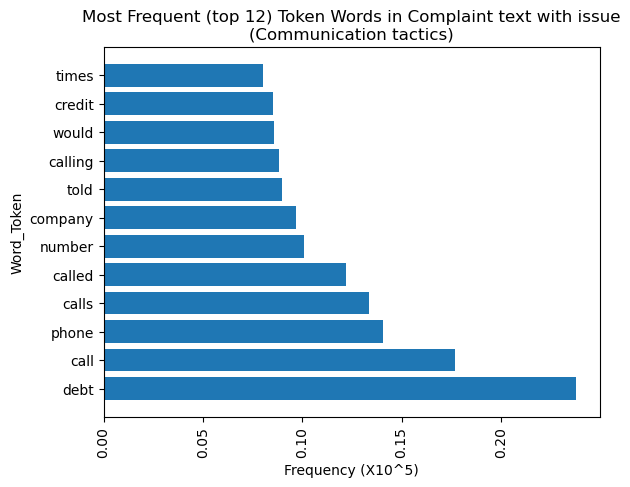

In [184]:
plt.barh((word_counts_comm_tactics[~word_counts_comm_tactics['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).words, 
         ((word_counts_comm_tactics[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[0:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 12) Token Words in Complaint text with issue\n(Communication tactics)")
plt.show()

In [185]:
##Now, let's fit a MultinomialNB model to our word count vectors.

In [186]:
from sklearn.naive_bayes import MultinomialNB

In [187]:
nb = MultinomialNB().fit(X_train_vec, y_train)

y_pred = nb.predict(X_test_vec)

In [188]:
accuracy_score(y_test, y_pred)

0.8243056655877227

In [189]:
confusion_matrix(y_test, y_pred)

array([[11898,  1957,   460,  3685,   291],
       [  590,  4498,    52,    91,    80],
       [   59,    53,  2824,   115,    36],
       [ 4919,   729,   700, 49383,  1595],
       [   29,    34,    16,    33,  4231]], dtype=int64)

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347

In [190]:
len(y_test) #88358
y_test.unique()
y_test.nunique()
y_test.value_counts()


Incorrect information on your report    57326
Attempts to collect debt not owed       18291
Communication tactics                    5311
Struggling to pay mortgage               4343
Fraud or scam                            3087
Name: Issue, dtype: int64

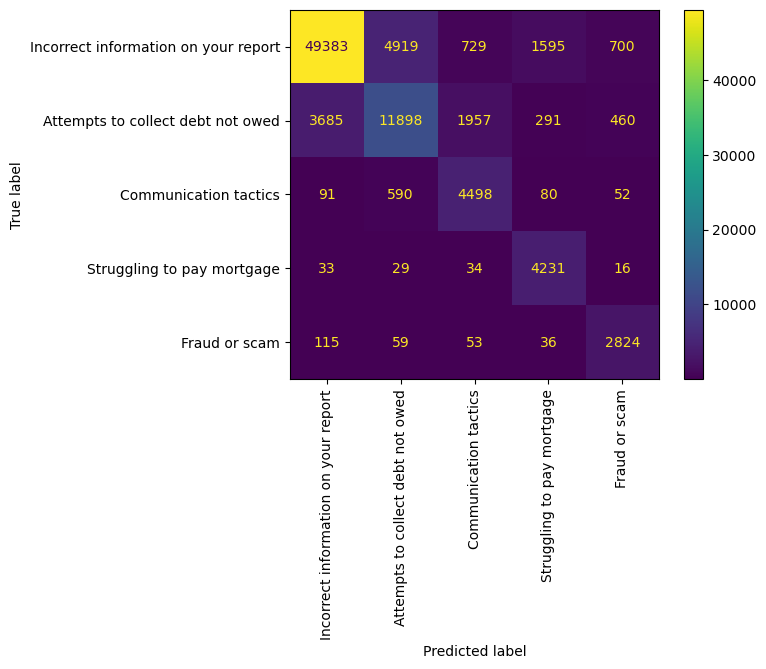

In [191]:
# from sklearn.metrics import plot_confusion_matrix

cm=confusion_matrix(y_test, y_pred, labels=['Incorrect information on your report',
                                            'Attempts to collect debt not owed',
                                            'Communication tactics', 
                                            'Struggling to pay mortgage',
                                            'Fraud or scam'])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Incorrect information on your report',
                                            'Attempts to collect debt not owed',
                                            'Communication tactics', 
                                            'Struggling to pay mortgage',
                                            'Fraud or scam'])
disp.plot()
plt.xticks(rotation = 90)
plt.show()

In [193]:
true_yespred = np.where(y_test == y_pred)
print("\nSum of true_yespred : ", np.size(true_yespred))
print("---------------------------------------------------")

true_notpred = np.where(y_test != y_pred)
print("\nSum of true_notpred : ", np.size(true_notpred))
print("---------------------------------------------------")




Sum of true_yespred :  72834
---------------------------------------------------

Sum of true_notpred :  15524
---------------------------------------------------


# old prediction
Sum of true_yespred :  71512
---------------------------------------------------

Sum of true_notpred :  16846
---------------------------------------------------

In [238]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=reviews["Issue"].sort_values().unique()))


                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.68      0.65      0.66     18291
               Communication tactics       0.62      0.85      0.71      5311
                       Fraud or scam       0.70      0.91      0.79      3087
Incorrect information on your report       0.93      0.86      0.89     57326
          Struggling to pay mortgage       0.68      0.97      0.80      4343

                            accuracy                           0.82     88358
                           macro avg       0.72      0.85      0.77     88358
                        weighted avg       0.84      0.82      0.83     88358



In [198]:
# we are getting some wrongly classified so going to find the index of the wrong classified


np.where(y_test != y_pred)

(array([    7,    11,    12, ..., 88333, 88344, 88347], dtype=int64),)

In [199]:
y_test.iloc[6]

'Incorrect information on your report'

In [202]:
i = 7

print(f'True Label: {y_test.iloc[i]}')
print(f'Predicted Label: {y_pred[i]}')
print(X_test.iloc[i, 0])

True Label: Attempts to collect debt not owed
Predicted Label: Communication tactics
kohn law firm, s.c. attorneys at law , wi        , wi  had a credit card judgement filed in  county court system for past due debt. credit card was closed and written off as bad debit by     for total amount due for  kohn law firm bought this debt and then started excessively calling me over the phone daily for the last year. the individual who had the account was   who works for kohn law firm. he would call me constantly asking me to take care of this debt. i did let him know due to losing my job at the time i would not be able to take care of this account but he still called constantly, daily. i finally said i would pay  a month for this past due debt on a  . credit card so he would leave me alone and i did make payments for  on //,  on // but since losing my job on // i was not able to keep up with payments and i did send them one last payment for  in // but they lost a check that i was paying on an

##Word_Vectors_for_Classification
vectorizing the complete complaint text
First, let's create an initial vector of zeros. Do this using the numpy zeros function. Make sure that the result will have the same shape as the word vectors from the matrix.

We'll also need to count the number of words in the review for which we have an embedding. We'll initialize a counter variable at 0.

In [213]:
reviews.head()
print(X_test.head())
print("-------")
print(y_test.head())
print("-------")
# print(y_pred)
print("-------")

                                          complaint_clean
49201   i have completely paid off my balance and it s...
46316   the   credit card debt was discharged in chapt...
175191  it appears that my credit file has been compro...
253139  submitted ftc report, statement and credential...
290709  ,   soc sec #  dob // address   ,  , fl  atten...
-------
49201     Incorrect information on your report
46316        Attempts to collect debt not owed
175191    Incorrect information on your report
253139    Incorrect information on your report
290709    Incorrect information on your report
Name: Issue, dtype: object
-------
-------


In [214]:
pd.DataFrame(y_pred, columns =['predicted_issue'])

,predicted_issue
0,Incorrect information on your report
1,Attempts to collect debt not owed
2,Incorrect information on your report
3,Incorrect information on your report
4,Incorrect information on your report
...,...
88353,Incorrect information on your report
88354,Fraud or scam
88355,Incorrect information on your report
88356,Incorrect information on your report


In [232]:
# df['y_pre']=y_pred
df_true_pred = pd.concat([X_test, y_test], axis=1)
df_true_pred['predicted_issue'] = y_pred
df_true_pred.shape #(88358, 3)
df_true_pred = df_true_pred.rename(columns = {'Issue':'true_issue'})

In [236]:
df_true_pred.groupby('true_issue')['predicted_issue'].value_counts().to_frame()

predicted_issue
true_issue                           predicted_issue                                      
Attempts to collect debt not owed    Attempts to collect debt not owed               11898
                                     Incorrect information on your report             3685
                                     Communication tactics                            1957
                                     Fraud or scam                                     460
                                     Struggling to pay mortgage                        291
Communication tactics                Communication tactics                            4498
                                     Attempts to collect debt not owed                 590
                                     Incorrect information on your report               91
                                     Struggling to pay mortgage                         80
                                     Fraud or scam                                      52
Fraud or scam                        Fraud or scam                                    2824
                                     Incorrect information on your report              115
                                     Attempts to collect debt not owed                  59
                                     Communication tactics                              53
                                     Struggling to pay mortgage                         36
Incorrect information on your report Incorrect information on your report            49383
                                     Attempts to collect debt not owed                4919
                                     Struggling to pay mortgage                       1595
                                     Communication tactics                             729
                                     Fraud or scam                                     700
Struggling to pay mortgage           Struggling to pay mortgage                       4231
                                     Communication tactics                              34
                                     Incorrect information on your report               33
                                     Attempts to collect debt not owed                  29
                                     Fraud or scam                                      16

In [ ]:
### find the text and labels for the wrongly predictd text and issues. to see what kind of word and their freuency in these text.

In [240]:
print(word_counts_incorrect_info.head(5))
print("----------")
print(word_counts_collect_debt.head(5))
print("----------")
print(word_counts_pay_mortagage.head(5))
print("----------")
print(word_counts_comm_tactics.head(5))
print("----------")
print(word_counts_fraud.head(5))
print("----------")

        words  frequency
0          00       4434
1         001          1
2  0017425527          1
3          01        237
4         010          4
----------
   words  frequency
0     00        656
1    001          1
2     01         61
3    010          1
4  01045          1
----------
   words  frequency
0     00       1320
1     01         31
2    010          4
3  01093          1
4    015          2
----------
  words  frequency
0    00         96
1    01          2
2    02          1
3    03          3
4    04          3
----------
  words  frequency
0    00        743
1    01          3
2   016          1
3   017          1
4    02          5
----------


In [246]:
df_comm = (word_counts_comm_tactics[~word_counts_comm_tactics['words'].str.isnumeric()])
df_incorrect_info = (word_counts_incorrect_info[~ word_counts_incorrect_info['words'].str.isnumeric()])
df_collect_debt = (word_counts_collect_debt[~ word_counts_collect_debt['words'].str.isnumeric()])
df_pay_mortgage = (word_counts_pay_mortagage[~word_counts_pay_mortagage['words'].str.isnumeric()])
df_fraud = (word_counts_fraud[~word_counts_fraud['words'].str.isnumeric()])

In [251]:
# print(df_comm.shape, df_fraud.shape, df_incorrect_info.shape, df_collect_debt.shape, df_pay_mortgage.shape)

(print(f'comm shape is: {df_comm.shape}', 
       f'collect_debt shape is: {df_collect_debt.shape}', 
       f'pay_mortage shape is: {df_pay_mortgage.shape}',
      f'fraud shape is: {df_fraud.shape}',
      f'incorrect_info shape is: {df_incorrect_info.shape}'))

comm shape is: (19668, 2) collect_debt shape is: (35481, 2) pay_mortage shape is: (28637, 2) fraud shape is: (21397, 2) incorrect_info shape is: (46572, 2)


In [253]:
comm = set(df_comm.words)
collect_debt = set(df_collect_debt.words)
pay_mortgage = set(df_pay_mortgage.words)
fraud = set(df_fraud.words)
incorrect_info =set(df_incorrect_info.words)

In [ ]:
incorrect_info & collect_debt
incorrect_info & pay_mortgage
incorrect_info & comm
incorrect_info & fraud


collect_debt & pay_mortgage
collect_debt & comm
collect_debt & fraud

pay_mortgage & comm
pay_mortgage & fraud


comm & fraud

In [ ]:
AB_overlap = A & B  #compute intersection of set A & set B
AC_overlap = A & C
BC_overlap = B & C
ABC_overlap = A & B & C
A_rest = A - AB_overlap - AC_overlap #see left graphic
B_rest = B - AB_overlap - BC_overlap
C_rest = C - AC_overlap - BC_overlap
AB_only = AB_overlap - ABC_overlap   #see right graphic
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

In [257]:
conda install -c conda-forge matplotlib-venn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\upadh\anaconda3

  added / updated specs:
    - matplotlib-venn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-venn-0.11.9     |     pyhd8ed1ab_0          30 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          30 KB

The following NEW packages will be INSTALLED:

  matplotlib-venn    conda-forge/noarch::matplotlib-venn-0.11.9-pyhd8ed1ab_0 




matplotlib-venn-0.11 | 30 KB     |            |   0% 
matplotlib-venn-0.11 | 30 KB     | #####2     |  53% 
matplotlib-venn-0.11 | 30 KB     | ########## | 100% 
                                                     


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may

In [263]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

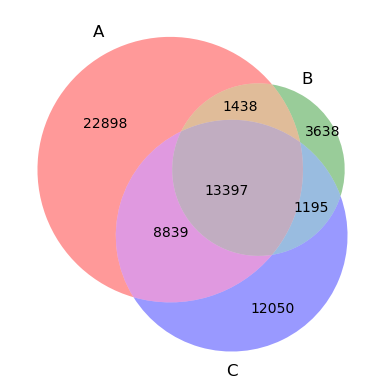

In [269]:
# from venn import venn

venn3([set(df_incorrect_info.words), set(df_comm.words), set(df_collect_debt.words)])
plt.show()

# sets = {
#     labels[0]: set(d1),
#     labels[1]: set(d2),
#     labels[2]: set(d3),
#     labels[3]: set(d4)
# }
# fig, ax = plt.subplots(1, figsize=(16,12))
# venn(sets, ax=ax)
# plt.legend(labels[:-2], ncol=6)

In [275]:
conda install -c conda-forge venn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\upadh\anaconda3

  added / updated specs:
    - venn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    venn-0.1.3                 |     pyhd8ed1ab_0          24 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          24 KB

The following NEW packages will be INSTALLED:

  venn               conda-forge/noarch::venn-0.1.3-pyhd8ed1ab_0 




venn-0.1.3           | 24 KB     |            |   0% 
venn-0.1.3           | 24 KB     | ######6    |  66% 
venn-0.1.3           | 24 KB     | ########## | 100% 
                                                     


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the ke

In [276]:
from venn import venn

<Axes: >

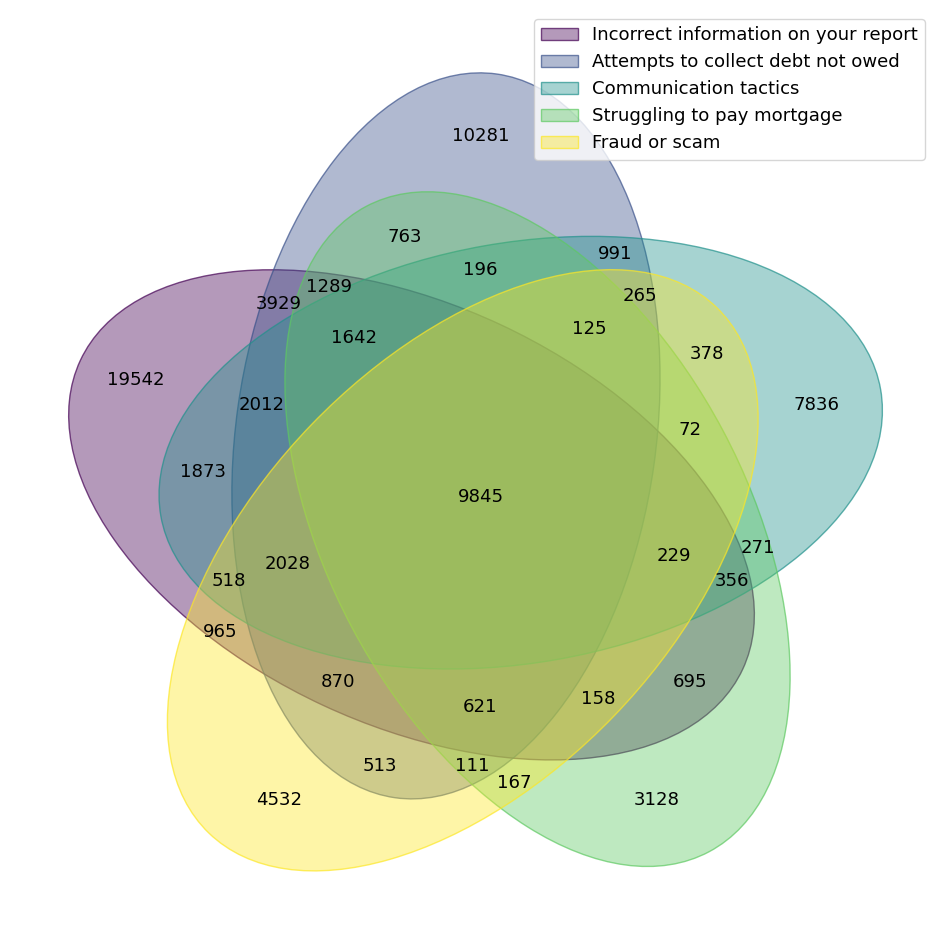

In [278]:
# comm = set(df_comm.words)
# collect_debt = set(df_collect_debt.words)
# pay_mortgage = set(df_pay_mortgage.words)
# fraud = set(df_fraud.words)
# incorrect_info =set(df_incorrect_info.words)

# from venn import venn

sets = {
    labels[0]: set(df_incorrect_info.words),
    labels[1]: set(df_collect_debt.words),
    labels[2]: set(df_pay_mortgage.words),
    labels[3]: set(df_comm.words),
    labels[4]: set(df_fraud.words)
}
fig, ax = plt.subplots(1, figsize=(16,12))
venn(sets, ax=ax)
# plt.legend(labels[:-2], ncol=6)